# 1. Vision Transformer Architecture

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer2 as Vit_2

2023-01-26 12:09:24.472963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 12:09:24.626278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 12:09:24.626301: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-26 12:09:25.220046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


### Comparison: CNN from [Kratz et al.](https://www.biorxiv.org/content/biorxiv/early/2022/09/03/2022.09.02.506331.full.pdf) and ViT

Load CNN and ViT models.

In [5]:
vit_new = Vit_2(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=12,
              n_heads=8,
              mlp_ratio=4.,
              p=0.,
              attn_p=0.,
              drop_path=0.).float()

In [6]:
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT_with_shifted_patch-2023-Jan-18 09:54:37/ViT_with_shifted_patch-2023-Jan-18 09:54:37.pth'

In [7]:
if torch.cuda.is_available():
    vit_new.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit_new.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [8]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/models/model_noise_1e-4.h5')

2023-01-26 13:42:49.811113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 13:42:49.821027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexrichard/PycharmProjects/UQ_DL-TFM/venv_3/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-26 13:42:49.821094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexrichard/PycharmProjects/UQ_DL-TFM/venv_3/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-26 13:42:49.821128: W tensorflow/core/common_

Load test set with clean samples.

In [9]:
os.getcwd()

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [10]:
dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements', 'r')['dspl'])
trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions', 'r')['trac'])
dspl_test = np.moveaxis(np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0), 3, 1)
trac_test = np.moveaxis(np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0), 3, 1)
X_test = torch.from_numpy(dspl_test).float()

cov = [[1e-04 ** 2, 0], [0, 1e-04 ** 2]]
X_test_noise = np.transpose(np.random.multivariate_normal(np.array([0, 0]), cov, (X_test.shape[0], X_test.shape[2], X_test.shape[3])), (0, 3, 2, 1))
X_test_noisy = X_test + X_test_noise
X_test_noisy = X_test_noisy.float()
Y_test = torch.from_numpy(trac_test).float()

Export test data to mat files.

In [11]:
save_files_here = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/mat_files_resolution_104'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
for i, sample in enumerate(X_test_noisy):
    sample = sample * 104
    file_name = f'{save_files_here}/test_sample_{i + 1}.mat'
    vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
    vec_noise = np.vstack([X_test_noise[i][0].reshape(-1), X_test_noise[i][1].reshape(-1)], dtype=np.double).T
    mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
    savemat(file_name, mdict=mdict)

Load BFFTC predictions.

In [10]:
bfftc_predictions = np.zeros((10, 2, 102, 102))
bfftc_displacements = np.zeros((10, 2, 102, 102))

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data predictions/results"
    
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        bfft_pred = loadmat(f'{directory}/{filename}')['TFM_results']['traction'][0][1].T.reshape((2, 102, 102), order='F')
        bfft_dspl = loadmat(f'{directory}/{filename}')['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')
        bfftc_predictions[i] = bfft_pred
        bfftc_displacements[i] = bfft_dspl

Find correct samples in test set and remove outer rims.

In [36]:
bfftc_predictions_trimmed = torch.zeros((10, 2, 98, 98))
ground_truths_trimmed = torch.zeros((10, 3, 98, 98))
X_test_noisy_small = torch.zeros((10, 2, 104, 104))

for i, sample in enumerate(bfftc_displacements):
    for j, dspl in enumerate(X_test_noisy):
        if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
            print(f'sample {i} matches with dspl {j}')
            bfftc_predictions_trimmed[i] = torch.tensor(bfftc_predictions[i, :, 3:101, 3:101]).float()
            ground_truths_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
            X_test_noisy_small[i] = dspl.float()

sample 0 matches with dspl 15
sample 1 matches with dspl 16
sample 2 matches with dspl 9
sample 3 matches with dspl 0
sample 4 matches with dspl 23
sample 5 matches with dspl 11
sample 6 matches with dspl 99
sample 7 matches with dspl 14
sample 8 matches with dspl 13
sample 9 matches with dspl 12


Compute MSE, DTMA and DDA for the predictions.

In [40]:
vit_new.eval()
pred_vit_new = vit_new(X_test_noisy_small, device=device)
pred_cnn = cnn.predict(np.moveaxis(np.array(X_test_noisy_small), 1, 3))

1/1 [==============================] - 0s 29ms/step


In [41]:
from MultiTask import append_predictions_and_targets, dtma, dda, multi_task_loss

mse = torch.nn.MSELoss(reduction='none')
mse_vit_new = torch.mean(mse(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed[:, 0:2]), (1, 2, 3))
mse_cnn = torch.mean(mse(torch.tensor(np.moveaxis(pred_cnn, 3, 1)[:, :, 3:101, 3:101]), ground_truths_trimmed[:, 0:2]), (1, 2, 3))
mse_bfftc = torch.mean(mse(bfftc_predictions_trimmed, ground_truths_trimmed[:, 0:2]), (1, 2, 3))

mse_vit_new = torch.reshape(mse_vit_new, (ground_truths_trimmed.shape[0], 1))
mse_cnn = torch.reshape(mse_cnn, (ground_truths_trimmed.shape[0], 1))
mse_bfftc = torch.reshape(mse_bfftc, (ground_truths_trimmed.shape[0], 1))

In [42]:
appended_multi_predictions, appended_multi_targets = append_predictions_and_targets(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, device)
dtma_vit_new = dtma(appended_multi_predictions, appended_multi_targets, device, True)
dda_vit_new = dda(appended_multi_predictions, appended_multi_targets, device, True)

In [43]:
appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, device)
dtma_cnn = dtma(appended_cnn_predictions, appended_cnn_targets, device, True)
dda_cnn = dda(appended_cnn_predictions, appended_cnn_targets, device, True)

In [44]:
appended_bfftc_predictions, appended_bfftc_targets = append_predictions_and_targets(bfftc_predictions_trimmed, ground_truths_trimmed, device)
dtma_bfftc = dtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dda_bfftc = dda(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [216]:
dtma_vit_new = torch.reshape(dtma_vit_new, (ground_truths_trimmed.shape[0], 1))
dtma_cnn = torch.reshape(dtma_cnn, (ground_truths_trimmed.shape[0], 1))
dtma_bfftc = torch.reshape(dtma_bfftc, (ground_truths_trimmed.shape[0], 1))
dda_vit_new = torch.reshape(dda_vit_new, (ground_truths_trimmed.shape[0], 1))
dda_cnn = torch.reshape(dda_cnn, (ground_truths_trimmed.shape[0], 1))
dda_bfftc = torch.reshape(dda_bfftc, (ground_truths_trimmed.shape[0], 1))

In [218]:
def highlight_closes_to_zero(s, props=''):
    return np.where(np.absolute(s) == np.nanmin(np.absolute(s.values)), props, '')

In [219]:
columns = ['MSE ViT', 
           'MSE CNN',
           'MSE BFFTC',
           'DTMA ViT', 
           'DTMA CNN',
           'DTMA BFFTC',
           'DDA ViT', 
           'DDA CNN',
           'DDA BFFTC']

metrics = pd.DataFrame(
    np.array(torch.cat((mse_vit_new, 
                        mse_cnn,
                        mse_bfftc,
                        dtma_vit_new, 
                        dtma_cnn,
                        dtma_bfftc,
                        dda_vit_new, 
                        dda_cnn,
                        dda_bfftc), 1).detach().numpy()), columns=columns)

float_formatter = "{:.6f}".format

averages = {}
for column in columns:
    averages[column] = f"avg: {float_formatter(round(metrics[column].mean(), ndigits=7))}"
    
averages = pd.DataFrame(averages, index=[0])

In [220]:
metrics = metrics.head(10)
metrics.index += 1 
metrics.loc['mean'] = metrics.mean()
slice_ = ['MSE ViT', 'MSE CNN', 'MSE BFFTC']
metrics = metrics.style.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DTMA ViT', 'DTMA CNN', 'DTMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DDA ViT', 'DDA CNN','DDA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
metrics = metrics.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
metrics.set_properties(**{'text-align': 'center'})

metrics.set_properties(**{"border": "0.5px solid black"})

,MSE ViT,MSE CNN,MSE BFFTC,DTMA ViT,DTMA CNN,DTMA BFFTC,DDA ViT,DDA CNN,DDA BFFTC
1,0.000024,0.000071,0.250872,0.018336,-0.060304,8.787394,0.129295,0.173241,0.331247
2,0.000023,0.000065,0.161532,-0.024343,-0.064620,8.334620,0.273405,0.281286,0.281973
3,0.000029,0.000077,0.311225,0.014330,-0.058971,8.643450,0.040214,0.059011,0.232818
4,0.000039,0.000114,0.398136,0.019902,-0.072425,8.798712,0.165956,0.109002,0.223000
5,0.000058,0.000124,0.395528,-0.023050,-0.065598,8.817811,0.168000,0.097485,0.294272
6,0.000021,0.000047,0.117428,-0.031065,-0.068853,8.428924,0.162548,0.177081,0.261889
7,0.000046,0.000107,0.320974,0.017616,-0.079514,8.571616,0.059260,0.101089,0.273418
8,0.000043,0.000090,0.255290,0.035365,-0.077794,8.913836,0.387076,0.191440,0.333262
9,0.000027,0.000071,0.195326,-0.024721,-0.081252,8.398847,0.124503,0.120709,0.292632
10,0.000018,0.000043,0.103201,-0.001849,-0.082644,8.009062,0.056468,0.111813,0.241523


Plot example cell.

In [259]:
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(precision=5)

In [260]:
torch.round(mse_cnn[0, 0], decimals=5)

tensor(7.00000e-05)

<IPython.core.display.Javascript object>


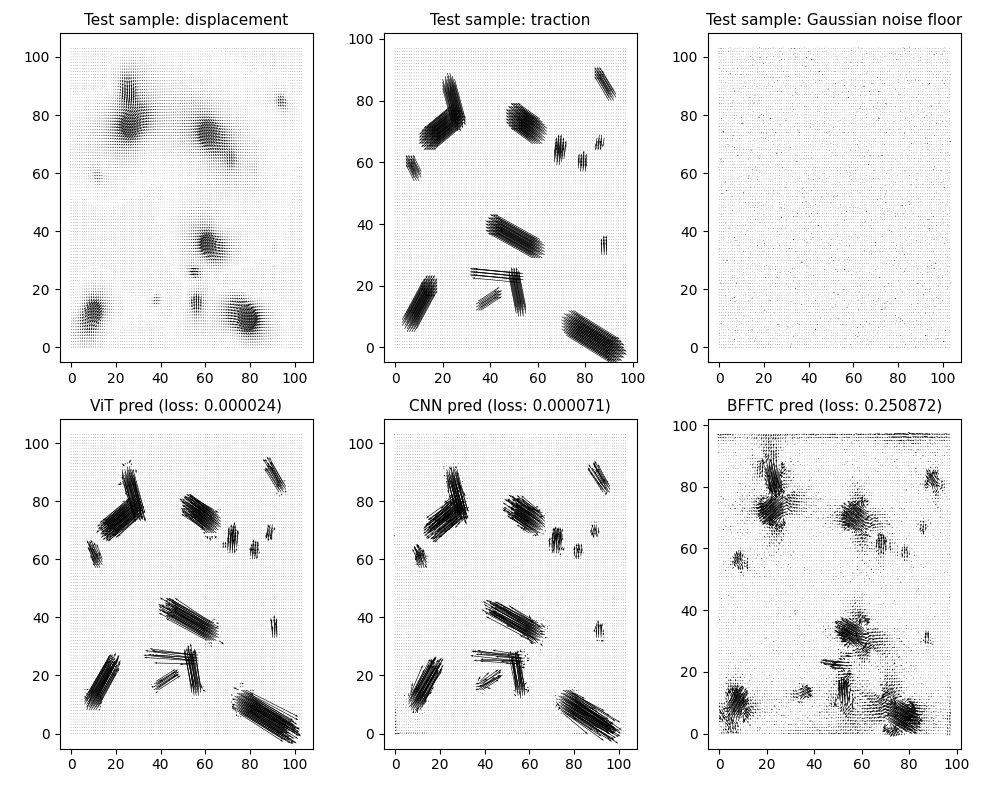

Text(0.5, 1.0, 'BFFTC pred (loss: 0.250872)')

In [275]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(X_test_noisy_small[0, 0, :, :].detach().numpy(), X_test_noisy_small[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Test sample: displacement', {'fontsize': 11})

axs[0, 1].quiver(ground_truths_trimmed[0, 0, :, :].detach().numpy(), ground_truths_trimmed[0, 1, :, :].detach().numpy(), scale=2)
axs[0, 1].set_title('Test sample: traction', {'fontsize': 11})

axs[0, 2].quiver(X_test_noise[0, 0, :, :], X_test_noise[0, 1, :, :], scale=0.05)
axs[0, 2].set_title(f'Test sample: Gaussian noise floor', {'fontsize': 11})

axs[1, 0].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=2)
axs[1, 0].set_title(f'ViT pred (loss:{mse_vit_new[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0, :, :, 0], pred_cnn[0, :, :, 1], scale=2)
axs[1, 1].set_title(f'CNN pred (loss:{mse_cnn[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 2].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=50)
axs[1, 2].set_title(f'BFFTC pred (loss:{mse_bfftc[0, 0]:9.6f})', {'fontsize': 11})

Visualize the first test sample, its ground truth and the models' predictions.

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(bfftc_displacements[0, 0, :, :], bfftc_displacements[0, 1, :, :], scale=1)
axs[0, 0].set_title('Displacement field returned by etutfm', {'fontsize': 11})

axs[0, 1].quiver(X_test_noisy[15, 0, :, :].detach().numpy(), X_test_noisy[15, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title(f'CNN prediction (loss: {torch.round(mse_cnn[0, 0], decimals=5)})', {'fontsize': 11})

axs[1, 0].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=50)
axs[1, 0].set_title(f'TFM prediction (loss: None)', {'fontsize': 11})

axs[1, 1].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 1].set_title(f'ViT prediction (loss: {torch.round(mse_vit_new[0, 0], decimals=5)})', {'fontsize': 11})

### Visualization of attention maps

In [ ]:
def compute_attention_map(attn_scores):
    """
    Compute the attention rollout tensors for each layer in a ViT architecture. We assume a batch size of 1.
    
    Parameters
    __________
    attn_scores : List
        List of raw attention tensors for each encoder block.
        
    Returns
    _______
    joint_attentions : List
        List of attention rollouts for each layer.
    
    grid_size : int
        Number of patches per dimension of original (quadratic) input.
    """
    # Stack raw attention tensors in a matrix, get rid of singleton (batch) dimension and average over all attention heads per layer.
    attn_mat = torch.stack(attn_scores) # (depth, n_samples, n_heads, n_patches, n_patches)
    attn_mat = attn_mat.squeeze(1) # (depth, n_heads, n_patches, n_patches)
    attn_mat = torch.mean(attn_mat, dim=1) # (depth, n_heads, n_patches, n_patches)
    
    # Account for skip connections in the architecture
    residual_attn = torch.eye(attn_mat.size(1))
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively compute attention rollouts 
    joint_attentions = torch.zeros(aug_attn_mat.size())
    joint_attentions[0] = aug_attn_mat[0].double()
    for n in range(1, aug_attn_mat.size(0)):
        joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
    grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
    
    return joint_attentions, grid_size

We extract the attention weights of each encoder block for the first test sample and compute the attention rollouts.

In [ ]:
_, attn_scores = vit((X_test[0, :, :, :][np.newaxis, ...]), return_attention=True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

Visualize the test sample and select one patch. We will then track the attention rollout of this patch among the network.

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0, 0, :, :], X_test[0 ,1 ,: , :], scale=1)
axs[0].set_title('Input as strain map', {'fontsize': 11})

C = np.sqrt(X_test[0, 0, :, :] **2 + X_test[0, 1, :, :] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input as heatmap', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 3 and column == 8:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(8*8, 3*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot rolled out attention map of chosen patch at each layer of the encoder.

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][47, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed.

In [ ]:
os.chdir('..')
sys.path.append(f"{os.getcwd()}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [ ]:
X_test_ = matFiles_to_npArray('comparables/generic')[1]
Y_test_ = matFiles_to_npArray('comparables/generic')[0]
X_test_ = np.moveaxis(np.array(X_test_['dspl'])[np.newaxis, ...], 3, 1)
Y_test_ = np.moveaxis(np.array(Y_test_['trac'])[np.newaxis, ...], 3, 1)

In [ ]:
_, attn_scores = vit(torch.tensor(X_test_).double(), True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test_[0,0,:,:], X_test_[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test_[0,0,:,:] **2 + X_test_[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test_[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 10})
        ind += 1